In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
from glob import glob
from tasks.week9.Week9Tasks import flux2mag
import matplotlib.pyplot as plt

In [2]:
def isGood(sweepdat, inds, flag = 'ALLMASK'):
    #general for one or multiple objects
    objs = sweepdat[inds]
    ii = (objs[flag] == 0)
    return ii
    
def magCuts(sweepdata, rmagcut):

    rmags = flux2mag(sweepdata['FLUX_R'])  
    magcuts = (rmags < rmagcut)
    return magcuts

def matchObj(objCoord,allsweepcoords,maxsep = 0.5*u.arcsec):
    seps = objCoord.separation(allsweepcoords)
    goodind = np.argmin(seps)
    if np.min(seps.to(u.arcsec).value) < maxsep.value:
        return goodind
    else:
        return None

def matchAllObj(objCoords,sweepcoords,maxsep = 0.5*u.arcsec):
    inds,seps,sep3d = objCoords.match_to_catalog_sky(sweepcoords)
    goodinds = inds[seps.to(u.arcsec).value < maxsep.value]
    return goodinds
    
def matchSurvey(objCoords,surveycen,maxsep = 3*u.deg):
    
    seps = surveycen.separation(objCoords)
    inds = seps.to(u.deg).value < maxsep.value
    return inds

def sweepCuts(sweepdata, cencoord, maxsep = 3*u.deg, minrmag = 20, colorcut = 0.5):
    
    print("Making Cuts")
    Allsweepcoords = SkyCoord(sweepdata['RA'],sweepdata['DEC'],unit=u.deg)
    isPSF = (sweepdata['TYPE'] == 'PSF')
    PSFs = sweepdata[isPSF]
    PSFcoords = Allsweepcoords[isPSF]
    
    inCircle = matchSurvey(cencoord,PSFcoords,maxsep=maxsep)
    #gets indices of coords in PSFcoords within 3deg of cencoord. maxsep must be in arcsec
    psfobjs = PSFs[inCircle]
    rmags = flux2mag(psfobjs['FLUX_R'])
    W1mags = flux2mag(psfobjs['FLUX_W1'])
    W2mags = flux2mag(psfobjs['FLUX_W2'])
    magcuts = magCuts(psfobjs, 20)
    brightpsfobjs = psfobjs[magcuts]
    
    return brightpsfobjs
    

In [3]:
sweepdir =os.path.join(os.getenv("ASTR5160"), 'data','legacysurvey','dr9','south','sweep','9.0')
sweepfile = os.path.join(sweepdir,'sweep-180p020-190p025.fits')

objcoord = SkyCoord(188.53667, 21.04572,unit=u.deg)
sweepdat = Table(fits.open(sweepfile)[1].data)
sweepcoords = SkyCoord(sweepdat['RA'],sweepdat['DEC'],unit=u.deg)
objind = matchObj(objcoord,sweepcoords)
print(f'TYPE = {sweepdat[objind]["TYPE"]}')
#Profile type is "EXP", which is a type of galactic profile.

goodbands = [isGood(sweepdat,objind,flag='ALLMASK_G'),isGood(sweepdat,objind,flag='ALLMASK_R'),
isGood(sweepdat,objind,flag='ALLMASK_Z')]
print(f'Good bands for g, r, and z: {goodbands}')
#Looks like none of the bands are good here

#Looking on the Legacy Survey Sky Viewer
#The object looks more like a foreground star than a galaxy
#It is indeed very saturated in the center
#The viewer shows Gaia data giving it a parallax of 1.3mas +/- 0mas
#leading me to believe that it is a star with a measurable parallax
#It also says that SDSS defined its profile with a PSF (point source profile)



TYPE = EXP
Good bands for g, r, and z: [False, False, False]


In [4]:
#4 files that includes area 3deg from RA=180deg Dec = +30deg
print('Reading Sweep files. This may take a minute...')
sweepfiles = [os.path.join(sweepdir,'sweep-180p030-190p035.fits'),os.path.join(sweepdir,'sweep-170p030-180p035.fits'),
os.path.join(sweepdir,'sweep-180p025-190p030.fits'),os.path.join(sweepdir,'sweep-170p025-180p030.fits')]
Allsweepdats = vstack([Table(fits.open(sweepf)[1].data) for sweepf in sweepfiles])


Reading Sweep files. This may take a minute...


In [5]:
cencoord = SkyCoord(180,30,unit=u.deg)
psfobjs = sweepCuts(Allsweepdats,cencoord)
print(len(psfobjs))
psfcoords = SkyCoord(psfobjs['RA'],psfobjs['DEC'],unit=u.deg)

Making Cuts
39655


/d/users/adamt/ASTR-5160/tasks/week9/Week9Tasks.py:37: RuntimeWarning: divide by zero encountered in log10
  mag = 22.5-2.5*np.log10(F)
/d/users/adamt/ASTR-5160/tasks/week9/Week9Tasks.py:37: RuntimeWarning: invalid value encountered in log10
  mag = 22.5-2.5*np.log10(F)


In [38]:
qsofile = os.path.join(os.getenv("ASTR5160"), 'week10','qsos-ra180-dec30-rad3.fits')
qsodat = Table(fits.open(qsofile)[1].data)
qsocoords = SkyCoord(qsodat['RA'],qsodat['DEC'],unit=u.deg)

matchQSOs = matchAllObj(qsocoords,psfcoords)
sweepqsos = psfobjs[matchQSOs]
qsocuts = magCuts(sweepqsos,20)
qsos = sweepqsos[qsocuts]
print(len(qsos))
    

275


---------------------------------------------------------

In [39]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [40]:
print("First few rows of the data:")
colnames = "sepal_length sepal_width petal_length petal_width" 
print(colnames)
print(iris.data[:3])
print("---------------------------------")
print("Column statistics:")
for i, j in enumerate(iris.data[0]):
      print("column: {}, mean: {:.2f}".format(i, np.mean(iris.data[..., i])))
print("---------------------------------")
print("Total number of rows: {}".format(len(iris.data)))
print("Target classes (which type of iris): {}".format(iris.target))
print("Target class names {}".format({i:j for i, j in enumerate(iris.target_names)}))


First few rows of the data:
sepal_length sepal_width petal_length petal_width
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
---------------------------------
Column statistics:
column: 0, mean: 5.84
column: 1, mean: 3.06
column: 2, mean: 3.76
column: 3, mean: 1.20
---------------------------------
Total number of rows: 150
Target classes (which type of iris): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Target class names {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


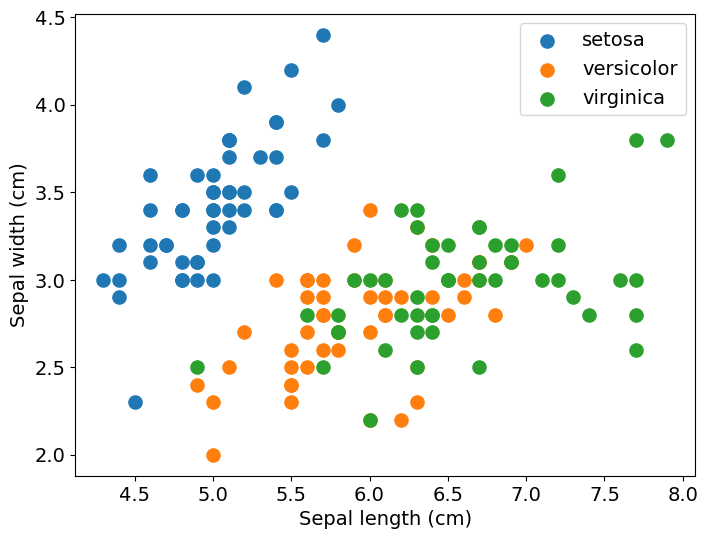

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i in range(3):
    target_class = iris.target == i
    ax.scatter(iris.data[target_class, 0], iris.data[target_class, 1], s=90, label=iris.target_names[i])
    ax.tick_params(labelsize=14)
    ax.set_xlabel("Sepal length (cm)", size=14)
    ax.set_ylabel("Sepal width (cm)", size=14)
    ax.legend(prop={'size': 14})

In [42]:
from sklearn import neighbors
# ADM use the k-nearest neighbors algorithm (k-NN)
# ADM with distances only to the nearest neighbor.
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(iris.data, iris.target)
print(colnames)
mock_data = [5, 4, 1, 0]
print(knn.predict([mock_data]), iris.target_names[knn.predict([mock_data])])
mock_data = [6, 3, 4, 1]
print(knn.predict([mock_data]), iris.target_names[knn.predict([mock_data])])

sepal_length sepal_width petal_length petal_width
[0] ['setosa']
[1] ['versicolor']


In [43]:
# ADM let's map out the entire sepal_length/sepal_width space!
# ADM (I'm restricting to just sepal_length and sepal_width as
# ADM it's easier to picture a 2-D space than a 4-D space).
n = 100000
mock_data = []
# ADM normally I don't condone appending to empty lists, but here
# ADM I want to explicitly illustrate which columns I'm working
# ADM on. This won't be a slow append, as it's only two columns.
for i in range(2):
    print("working on column: {}".format(colnames.split()[i]))
    col_min = np.min(iris.data[..., i])
    col_max = np.max(iris.data[..., i])
    # ADM generate random points in the space corresponding to the
    # ADM iris measurement of interest.
    mock_meas = np.random.random(n)*(col_max - col_min) + col_min
    mock_data.append(mock_meas)
# ADM we now have a list of n*2 measurements, 
# ADM but we want an array of 2 columns and n rows.
mock_data = np.reshape(mock_data, (2, n)).T
mock_data

working on column: sepal_length
working on column: sepal_width


array([[6.19679228, 2.49354545],
       [4.53080559, 2.41037741],
       [4.48439443, 3.98324293],
       ...,
       [6.94054199, 3.84332409],
       [5.2772176 , 3.81937364],
       [7.81026613, 3.84373065]])

In [44]:
# ADM classify using the k-NN "black box"
# ADM trained on the real-world iris data.
# ADM but only use 2 columns as a simple illustration.
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(iris.data[..., :2], iris.target)
mock_target_class = knn.predict(mock_data)
# ADM again, this for loop isn't strictly necessary, but
# ADM it's a clear way to print the information to screen.
for i in range(10):
    print(mock_data[i], mock_target_class[i], iris.target_names[mock_target_class[i]])

[6.19679228 2.49354545] 1 versicolor
[4.53080559 2.41037741] 0 setosa
[4.48439443 3.98324293] 0 setosa
[6.71442319 3.37931484] 2 virginica
[7.77506213 2.99538973] 2 virginica
[5.01638629 3.7275869 ] 0 setosa
[7.3781373  2.59339684] 2 virginica
[5.96182908 2.7462704 ] 1 versicolor
[4.59544528 2.97306696] 0 setosa
[7.62456471 3.67718039] 2 virginica


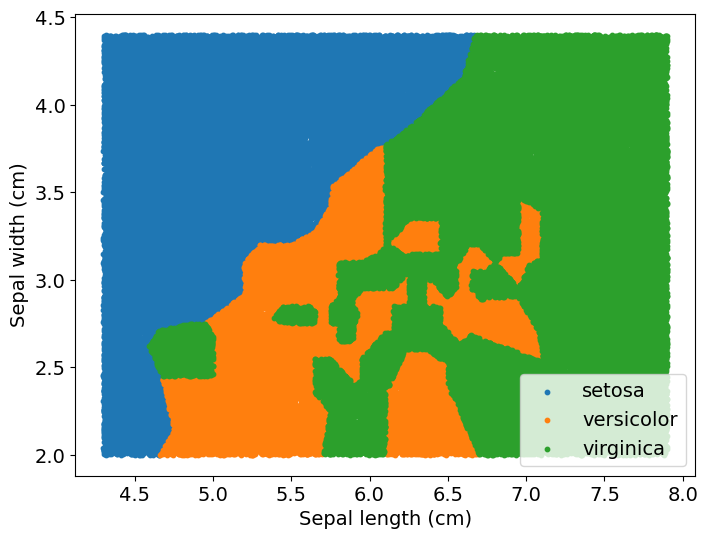

In [45]:
# ADM let's plot the sepal_length, sepal_width space of the k-NN classifier.
fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i in range(3):
    target_class = mock_target_class == i
    ax.scatter(mock_data[target_class, 0], mock_data[target_class, 1], s=10, label=iris.target_names[i])
    ax.tick_params(labelsize=14)
    ax.set_xlabel("Sepal length (cm)", size=14)
    ax.set_ylabel("Sepal width (cm)", size=14)
    ax.legend(prop={'size': 14})

In [46]:
#CHECKING FRACTION OF EACH CLASS IDENTIFIED

fracset = np.sum(mock_target_class == 0)/n
fracvers = np.sum(mock_target_class == 1)/n
fracvirg = np.sum(mock_target_class == 2)/n

fracs = [fracset,fracvers,fracvirg]

for i in range(3):
    print(f' Percent identified as {iris.target_names[i]}: {fracs[i]*100:.2f}%')

 Percent identified as setosa: 33.56%
 Percent identified as versicolor: 21.48%
 Percent identified as virginica: 44.95%


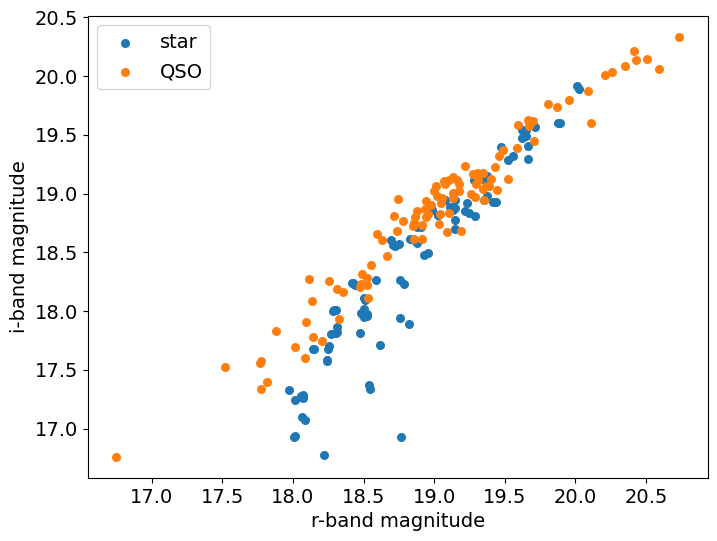

In [48]:
MLqsos = np.array([
        [18.744722,18.394268,18.309591,18.184225,18.261715],[19.688782,19.054688,19.176489,19.02421,18.696566],[19.563297,19.471746,19.38908,19.067038,19.207346],[19.029963,18.972807,18.958265,18.823439,18.692583],[18.149904,18.051216,18.112373,18.269794,17.576611],[19.233286,19.249971,19.067638,19.106289,18.923378],[19.342098,19.114586,19.048199,18.923874,19.003283],[19.572979,19.539234,19.593983,19.58787,19.839739],[19.451731,19.517733,19.291042,18.968428,19.06872],[19.305523,18.724361,18.139717,17.776787,17.693134],[19.358782,19.263777,19.133242,18.959019,18.794546],[19.572119,19.517012,19.309811,19.112907,19.153662],[19.551817,19.186308,18.852896,18.728289,18.694551],[18.16538,18.106567,18.094177,17.904747,17.910076],[19.453842,19.284033,19.102739,18.83543,18.96608],[19.854441,19.243029,18.528109,18.219172,18.114115],[20.241364,20.597746,20.206196,20.01281,19.859661],[19.862375,19.731724,19.702806,19.616152,19.490868],[18.845604,18.700039,18.667009,18.467548,18.478443],[19.482214,19.203161,19.032568,18.737476,18.744768],[19.3901,19.198641,19.013081,19.064732,18.865631],[20.719276,20.281059,19.662498,19.624067,19.32023],[19.56996,18.999855,18.937254,18.869497,18.590803],[17.922159,17.750494,17.517071,17.523623,17.361856],[21.113659,19.708879,18.911526,18.615511,18.395302],[22.712126,20.320133,19.86651,19.737288,19.70672],[19.800406,18.592144,17.817379,17.399628,17.060135],[22.647556,21.77388,20.735937,20.335043,19.775301],[20.881166,20.447176,20.348919,20.088438,20.099693],[19.402994,19.042908,18.94466,18.93589,18.843378],[18.903831,18.572012,18.352116,18.158442,18.000324],[19.914022,19.80702,19.525486,19.125696,18.892767],[19.332512,19.08815,18.854038,18.616337,18.555649],[19.259775,18.842321,18.864609,18.796721,18.658291],[18.393356,18.218657,18.018612,17.694494,17.581081],[18.694517,18.643589,18.597673,18.65523,18.452408],[20.336267,20.060621,19.405148,19.127205,18.881546],[18.658436,18.392712,18.137266,18.08651,18.109537],[19.511658,19.339643,19.001104,19.020147,19.032293],[19.610483,19.518547,19.175377,19.084261,18.924337],[20.707575,20.182711,19.369616,19.060297,18.839787],[19.601027,18.958122,18.881411,18.8493,18.668055],[19.532183,19.280308,19.297268,19.07955,19.029108],[18.781235,18.52058,18.253962,18.253763,18.105644],[20.283949,20.171352,20.088402,19.87583,19.820202],[19.820608,19.679596,19.588165,19.389709,19.168039],[22.094894,21.437128,20.592884,20.062315,19.739923],[19.526564,19.272533,19.07749,19.07902,18.948053],
        [18.902395,18.322453,17.777796,17.338715,17.216942],[20.018803,19.598724,19.489754,19.370985,19.299452],[21.604231,19.705097,19.355795,18.941904,18.658649],[21.492113,20.53562,20.504961,20.145609,19.690453],[20.506151,19.143932,18.914755,18.733116,18.68424],[19.779257,19.587122,19.346659,19.172829,19.228399],[19.080269,18.923189,18.714451,18.805676,18.715391],[23.893023,20.949961,20.108637,19.602491,19.402994],[19.475689,19.497339,19.21969,19.232433,19.362291],[20.722937,20.438725,20.412531,20.209305,20.110937],[20.378387,19.978376,19.957357,19.798298,19.801628],[19.394093,19.159006,19.039072,18.823759,18.833567],[18.6556,18.559763,18.525602,18.279596,18.298143],[19.82836,19.361555,19.132957,19.00437,18.755081],[18.314793,17.968035,17.770653,17.55607,17.568619],[20.738749,20.25322,20.429714,20.134119,19.80547],[18.92709,18.789314,18.328901,17.930676,17.71903],[20.765722,20.425152,20.261223,20.032152,19.987698],[21.898718,20.366604,19.190598,18.685432,18.564209],[19.209698,18.843922,18.082823,17.598646,17.454884],[20.571241,19.715168,19.346649,19.035482,18.673683],[19.700674,19.372719,19.263952,18.997389,18.928925],[19.755407,19.536802,19.430946,19.222158,19.370178],[19.109722,18.664597,18.477087,18.20159,18.220667],[22.367666,20.430206,19.458319,19.31806,19.301077],[20.666672,20.259563,19.443361,19.033512,18.698406],[18.640318,18.900045,18.630014,18.609161,18.669069],[19.134163,19.020254,18.747284,18.952831,19.055578],[21.476528,19.508688,19.135096,19.140932,19.117966],[19.61648,19.265966,19.163887,19.116779,19.071653],[18.611923,18.521744,18.484806,18.22971,18.105438],[19.663836,18.972357,18.550348,18.392038,18.211784],[19.677265,19.40823,19.089659,18.671545,18.642952],[19.203194,19.177202,19.019161,18.976236,19.129333],[19.157156,19.094862,19.058044,18.95915,18.794933],[17.064066,16.845049,16.747282,16.760361,16.699829],[19.263111,19.05188,18.779545,18.766621,18.74962],[21.415379,18.908577,18.490671,18.3186,18.210991],[19.178915,18.984844,18.734407,18.681,18.757259],[19.153744,18.989044,18.858898,18.750517,18.556971],[21.874535,19.867119,19.67396,19.572515,19.232058],[19.40521,19.081427,18.945744,18.801537,18.811073],[18.206612,17.959349,17.774895,17.571123,17.494965],[19.324575,19.241135,18.977043,18.90477,19.002703],[19.256691,18.664949,18.208923,17.746832,17.563005],[18.234364,17.920656,17.877764,17.82852,17.7251],[19.474617,19.370167,19.275578,19.164686,18.90004],[19.953865,19.784174,19.708263,19.449259,19.312752],[19.755163,19.178165,18.529041,18.113386,17.857853],[19.727612,19.195156,19.101727,19.117582,19.022566],[19.894958,19.867922,19.807981,19.763544,19.343872],[19.901382,19.600948,19.302818,19.175266,18.703302]
    ])

stars = np.array([
        [22.44946,19.97534,18.54526,17.33972,16.67254],[20.77815,19.4398,18.87869,18.71637,18.68406],[22.61502,20.0222,18.53809,17.37034,16.69467], [22.67518,20.3125,18.82124,17.89092,17.40948], [23.37306,20.26618,18.75942,17.93758,17.4218], [20.87663,19.24346,18.82649,18.61213,19.03254], [21.2547,19.44574,18.59049,18.26796,18.11473], [21.14091,19.84629,19.35966,19.11529,19.03632], [23.34694,20.00362,18.47734,17.81385,17.38007], [20.54105,19.3501,18.90781,18.71399,18.53207], [20.81281,19.75167,19.37374,19.15161,19.11015], [21.19628,19.91164,19.38225,19.06724,19.00649], [23.42917,20.47683,19.41293,18.92953,18.66926], [22.23457,19.4957,17.97546,17.33125,16.91896], [21.84833,20.16281,18.61554,17.70773,17.20546], [21.87615,19.51687,18.07097,17.28559,16.8108], [20.15546,19.30957,18.97326,18.88849,18.87114], [20.20057,19.31459,18.98439,18.86432,18.8286], [20.25109,19.29368,18.96605,18.85745,18.78543], [22.06602,19.48195,18.0576,17.27881,16.86323], [22.10527,19.50775,18.0136,17.24724,16.80717], [20.18234,19.29664,18.97465,18.86959,18.75895], [21.84393,19.52566,18.0703,17.25718,16.82474], [21.78772,19.53626,18.22131,16.77889,16.10115], [20.44573,19.01728,18.42748,18.23824,18.12197], [20.53322,19.02352,18.44298,18.22176,18.1349], [20.59585,19.01741,18.41915,18.24291,18.08544], [20.75146,19.64077,19.28507,19.11219,19.0484], [20.57132,19.30027,18.72266,18.55597,18.40891], [21.2337,19.77214,19.02792,18.81852,18.69435], [20.70082,19.25805,18.75136,18.56669,18.42665], [20.70589,19.8298,19.47613,19.40005,19.39293], [21.6109,19.78855,19.02922,18.81845,18.6857], [22.80736,20.32154,18.76478,16.92489,15.8764], [21.56886,19.43514,18.27148,17.80843,17.53949], [20.34764,19.34764,19.07848,18.94273,18.89366], [21.50406,19.62864,18.52377,17.95594,17.628], [21.37426,19.94507,19.23395,18.91821,18.75806], [20.9035,19.08836,18.30525,18.0126,17.84013], [21.71455,20.42793,19.44023,18.93189,18.62866], [20.86752,19.06702,18.29345,18.00766,17.82436], [21.98555,19.52187,18.51127,18.09584,17.88142], [21.67668,19.5505,18.50358,18.10969,17.87844],[22.53292,19.7276,18.48423,17.98095,17.70833],[20.8909,19.0599,18.28369,18.00476,17.87395],[22.35347,20.25845,18.95716,18.49136,17.97949],[21.76183,19.88117,18.75925,18.26558,17.91661],[22.23183,19.74561,18.488,17.97591,17.71163],[21.29818,19.79457,19.14499,18.88091,18.72307], [22.0105,19.70986,18.52199,17.97292,17.61687],
        [22.86553,19.94115,18.7831,18.23227,17.90711],[21.18186,19.79757,19.13424,18.85658,18.71214],[20.0074,19.05439,18.69278,18.60722,18.52868],[21.58379,20.33799,19.66424,19.2912,19.09761],[21.98114,20.2121,19.55524,19.32269,19.07644],[22.81192,19.89781,18.5065,17.95065,17.61704],[21.83415,20.23835,19.52526,19.28796,19.1398],[22.63741,20.26673,19.21909,18.85295,18.62377],[19.89656,19.03701,18.70751,18.5632,18.56942],[21.30959,19.37278,18.31021,17.86578,17.56223],[21.22793,19.36349,18.30933,17.81932,17.51374],[21.14737,19.33545,18.30335,17.81113,17.4971],[22.21014,20.27786,19.2433,18.83222,18.65571],[20.18058,19.31195,19.06964,18.94653,18.89464],[22.35099,20.28571,19.28649,18.80538,18.62735],[20.24579,19.3125,19.05523,18.95683,18.98032],[21.80952,20.44154,20.00894,19.91379,19.79607],[22.21284,19.61759,18.24859,17.67601,17.37054],[21.68078,20.48232,20.02647,19.88837,19.78827],[23.75356,20.39333,19.35249,18.94558,18.62885],[23.42696,20.37005,19.37519,18.97837,18.63843],[22.65762,19.64814,18.25478,17.70169,17.37972],[21.21484,20.05256,19.62379,19.53748,19.36399],[21.19142,20.05359,19.71335,19.56334,19.70693],[20.98901,20.05082,19.68979,19.58001,19.68044],[20.77375,20.00404,19.64923,19.53775,19.54221],[21.86685,19.9237,19.11284,18.88337,18.71919],[21.93681,19.90158,19.12132,18.86649,18.70179],[21.70023,20.09205,19.14815,18.7781,18.55863],[21.79366,20.03435,19.14712,18.70042,18.51328],[21.62113,19.99053,19.14881,18.94777,18.46128],[20.99038,19.95668,19.61966,19.47392,19.42933],[22.07217,19.46344,18.08623,17.07386,16.53181],[20.9025,19.97484,19.64865,19.49392,19.34935],[20.89883,19.97347,19.66507,19.40612,19.44094],[21.04365,19.97419,19.63968,19.50207,19.40869],[21.00765,19.95171,19.63981,19.48675,19.35925],[22.15741,19.48624,18.06823,17.09778,16.57183],[22.16418,19.77536,18.5058,18.01847,17.66681],[22.94029,19.56238,18.00614,16.93008,16.35485],[21.88229,20.49575,19.87854,19.59909,19.45779],[21.98588,20.47682,19.89064,19.59884,19.41466],[22.5875,19.57998,18.01291,16.93524,16.34619],[24.41736,19.71074,18.24074,17.58002,17.19191],[22.06751,19.64084,18.23813,17.5793,17.18487],[21.71258,19.76319,18.92926,18.4789,18.18599],[21.07738,19.50764,18.88156,18.57879,18.49265],[21.55381,19.24872,18.14714,17.67999,17.32854],[21.64327,19.25232,18.14592,17.67702,17.38654],[21.04674,19.48493,18.854,18.60168,18.56519]
    ])

data = np.concatenate([stars, MLqsos])
data_class = np.concatenate([np.zeros(len(stars), dtype='i'), 
                            np.ones(len(MLqsos), dtype='i')])
target_names = np.array(["star", "QSO"])

# ADM let's plot some of the qso and star colors.
fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i in range(2):
    target_class = data_class == i
    ax.scatter(data[target_class, 2], data[target_class, 3], s=30, label=target_names[i])
    ax.tick_params(labelsize=14)
    ax.set_xlabel("r-band magnitude", size=14)
    ax.set_ylabel("i-band magnitude", size=14)
    ax.legend(prop={'size': 14})

In [49]:
# ADM classify using the k-NN "black box"
# ADM trained on the real-world astro data.
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(data, data_class)
qsolike = [19.03,18.97,18.95,18.82,18.69]
starlike = [20.00,19.05,18.69,18.61,18.53]
predicted_class = knn.predict([qsolike])
print(predicted_class, target_names[predicted_class])
predicted_class = knn.predict([starlike])
print(predicted_class, target_names[predicted_class])

[1] ['QSO']
[0] ['star']


-----------------------------------------------------

In [86]:
def choose_subset(dat,length = 100):
    allinds = np.arange(0,len(dat))
    subinds = random.choice(allinds,size=length,replace=False)
    subdat = dat[subinds]
    nans = (np.isnan(subdat)) | (np.isinf(subdat))
    while nans.any():
        for i in range(len(nans)):
            if nans[i].any():
                subdat[i] = dat[random.choice(allinds,size=1,replace=False)]
        nans = (np.isnan(subdat)) | (np.isinf(subdat))
    return subdat
        

In [87]:
from numpy import random

psfg_z = flux2mag(psfobjs['FLUX_G']) - flux2mag(psfobjs['FLUX_Z'])
qsog_z = flux2mag(qsos['FLUX_G']) - flux2mag(qsos['FLUX_Z'])

psfr_W1 = flux2mag(psfobjs['FLUX_R']) - flux2mag(psfobjs['FLUX_W1'])
qsor_W1 = flux2mag(qsos['FLUX_R']) - flux2mag(qsos['FLUX_W1'])

psfdat = np.column_stack([psfg_z,psfr_W1])
qsodat = np.column_stack([qsog_z,qsor_W1])

#making small subset up psfdat that is same length as qsodat
psfdat_sub = choose_subset(psfdat,len(qsodat))

fulldat = np.concatenate([psfdat_sub,qsodat])
dat_class = np.concatenate([np.zeros(len(psfdat_sub), dtype='i'), 
                            np.ones(len(qsodat), dtype='i')])

#0s are stars. 1s are QSOs

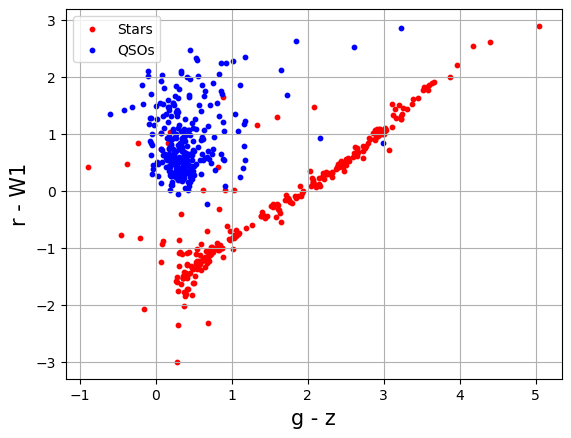

In [88]:
plt.figure()
plt.scatter(psfdat_sub[:,0],psfdat_sub[:,1],c='r',s=10,label='Stars')
plt.scatter(qsodat[:,0],qsodat[:,1],c='b',s=10,label='QSOs')
plt.xlabel('g - z',fontsize=15)
plt.ylabel('r - W1',fontsize=15)
plt.grid()
plt.legend()

In [89]:
qsoknn = neighbors.KNeighborsClassifier(n_neighbors = 3)  #3 seems reasonable here
qsoknn.fit(fulldat,dat_class)

KNeighborsClassifier(n_neighbors=4)

In [90]:
def gen_mock_dat(g_zdat,r_W1dat,n):
    ming_z = np.nanmin(g_zdat)
    maxg_z = np.nanmax(g_zdat)
    minr_W1 = np.nanmin(r_W1dat)
    maxr_W1 = np.nanmax(r_W1dat)
    
    mockg_z = np.random.choice(np.linspace(ming_z,maxg_z,n),size=n)
    mockr_W1 = np.random.choice(np.linspace(minr_W1,maxr_W1,n),size=n)
    mockdat = np.column_stack([mockg_z,mockr_W1])
    return mockdat
    

In [91]:
n = 100000
combg_z = np.concatenate([psfg_z,qsog_z])
combr_W1 = np.concatenate([psfr_W1,qsor_W1])
combg_z = combg_z[~np.isinf(combg_z)]
combr_W1 = combr_W1[~np.isinf(combr_W1)]
mockdat = gen_mock_dat(combg_z,combr_W1,n)

In [92]:
mock_class = qsoknn.predict(mockdat)

In [93]:
numqso = np.sum(mock_class)  #0s are stars. 1s are QSOs
fracqso = numqso/n

In [94]:
print(f'Fraction of point-like objects classified as QSO is {fracqso*100:.2f}')

Fraction of point-like objects classified as QSO is 24.21


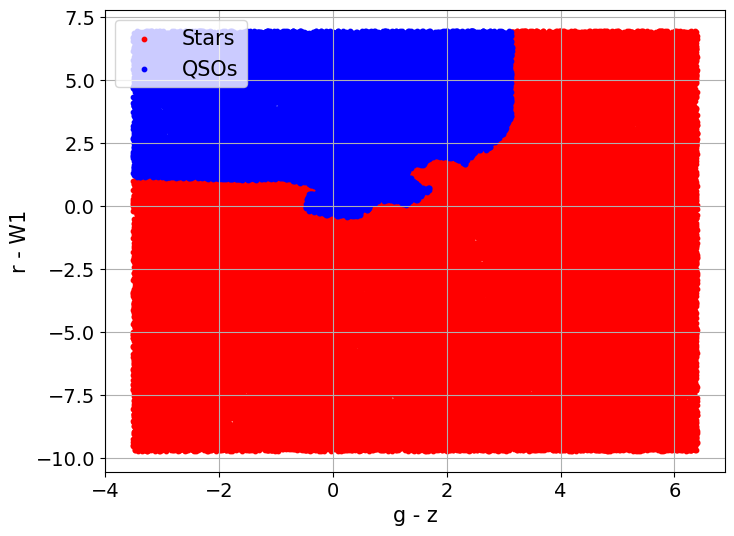

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
colors = ['r','b']
labs = ['Stars','QSOs']
for i in range(2):
    target_class = mock_class == i
    ax.scatter(mockdat[target_class, 0], mockdat[target_class, 1], s=10, c= colors[i], label=labs[i])
    ax.tick_params(labelsize=14)
    ax.set_xlabel("g - z", size=15)
    ax.set_ylabel("r - W1", size=15)
    ax.legend(prop={'size': 15})
plt.grid()